In [2]:
import pandas as pd
import numpy as np
import datetime
import random

In [255]:
data = pd.read_csv('../assignment-1/data/train.csv')

In [4]:
# Encoding groups

#property_type_groups = [['Apartment','Serviced apartment'], ['House','Townhouse','Chalet'],['Condominium'],['Guesthouse','Guest suite'],['Loft'],['Bed & Breakfast'],['Other','Boutique hotel','Hostel','Camper/RV','Castle','Boat','Timeshare'],['Villa'],['Cabine','Earth House','Yurt','Dorm','Tent']]
property_type_groups = [[property_type] for property_type in data['property_type'].dropna().str.split(', ').explode().unique().tolist()]
#property_room_type_groups = [['Private room'],['Entire home/apt'],['Shared room']]
property_room_type_groups = [[property_room_type] for property_room_type in data['property_room_type'].dropna().str.split(', ').explode().unique().tolist()]
#booking_cancel_policy_groups = [['flexible'],['moderate'],['strict', 'super_strict_30']]
booking_cancel_policy_groups = [[booking_cancel_policy] for booking_cancel_policy in data['booking_cancel_policy'].dropna().str.split(', ').explode().unique().tolist()]
#property_bed_type_groups = [['Couch','Airbed','Futon','Pull-out Sofa'],['Real Bed']]
property_bed_type_groups = [[property_bed_type] for property_bed_type in data['property_bed_type'].dropna().str.split(', ').explode().unique().tolist()]
host_response_time_groups = [['a few days or more'],['within a day'],['within a few hours'],['within an hour'],['']]
amenity_groups = [[amenity] for amenity in data['property_amenities'].dropna().str.split(', ').explode().unique().tolist()]  # Each ammenity is a separate group
host_verified_groups = [[verification] for verification in data['host_verified'].dropna().str.split(', ').explode().unique().tolist()]  # Each host_verified status is a separate group
extra_groups = [[extra] for extra in data['extra'].dropna().str.split(', ').explode().unique().tolist()]  # Each extra comment is a separate group

In [168]:
def preprocessing(data):

    df = data.copy()

    # Replace NaN values with empty string
    df[['host_response_time','property_amenities','host_verified','extra']] = df[['host_response_time','property_amenities','host_verified','extra']].fillna('')

    # Count amenities
    df['amenities_count'] = df['property_amenities'].apply(lambda x: 0 if pd.isna(x) else x.count(',') + 1)

    # Property city 
    df['property_city'] = df['property_lat'].apply(lambda x: 1 if x > 51 else 0)

    # OneHotEncoding
    for group in property_type_groups:
        group_name = 'property_type' + '_' + group[0]
        df[group_name] = df['property_type'].isin(group).astype(int)
    for group in property_room_type_groups:
        group_name = 'property_room_type' + '_' + group[0]
        df[group_name] = df['property_room_type'].isin(group).astype(int)
    for group in booking_cancel_policy_groups:
        group_name = 'booking_cancel_policy' + '_' + group[0]
        df[group_name] = df['booking_cancel_policy'].isin(group).astype(int)
    for group in property_bed_type_groups:
        group_name = 'property_bed_type' + '_' + group[0]
        df[group_name] = df['property_bed_type'].isin(group).astype(int)
    for group in host_response_time_groups:
        group_name = 'host_response_time' + '_' + group[0]
        df[group_name] = df['host_response_time'].isin(group).astype(int)

    # MultiLabelEncoding
    for group in amenity_groups:
        new_col = df['property_amenities'].apply(lambda x: 1 if len(set(x.split(', ')).intersection(group)) > 0 else 0)
        group_name = 'property_amenities' + '_' + group[0]
        df = pd.concat([df, new_col.rename(group_name)], axis=1)
    for group in host_verified_groups:
        new_col = df['host_verified'].apply(lambda x: 1 if len(set(x.split(', ')).intersection(group)) > 0 else 0)
        group_name = 'host_verified' + '_' + group[0]
        df = pd.concat([df, new_col.rename(group_name)], axis=1)
    for group in extra_groups:
        new_col = df['extra'].apply(lambda x: 1 if len(set(x.split(', ')).intersection(group)) > 0 else 0)
        group_name = 'extra' + '_' + group[0]
        df = pd.concat([df, new_col.rename(group_name)], axis=1)

    '''
    # iterate through each column in the dataframe
    for col in df.columns:
        # check if the column is binary
        if set(df[col]) == {0, 1}:
            # calculate the percentage of 1's and 0's
            counts = df[col].value_counts(normalize=True)
            # check if the percentage of 1's or 0's is less than 10%
            if 0 in counts.index and counts[0] < 0.1:
                print(col)
                df = df.drop(col, axis=1)
            elif 1 in counts.index and counts[1] < 0.1:
                print(col)
                df = df.drop(col, axis=1)
    '''

    # Convert property_last_updated to days
    def convert_to_days(value, property_scraped_at, host_since):
        if value == 'today':
            return 0
        elif value == 'yesterday':
            return 1
        elif value == 'never':
            property_scraped_at = datetime.datetime.strptime(property_scraped_at, '%Y-%m-%d')
            host_since = datetime.datetime.strptime(host_since, '%Y-%m-%d')
            difference = property_scraped_at - host_since
            return difference.days
        else:
            # split the string to get the number and unit
            if value.endswith('day ago'):
                return 1
            elif value.endswith('week ago'):
                return 7
            elif value.endswith('month ago'):
                return 30
            else:
                number, unit, _ = value.split()
                # convert the number to an integer
                number = int(number)
                # convert the unit to a number of days
                if unit == 'days':
                    return number
                elif unit == 'weeks':
                    return number * 7
                elif unit == 'months':
                    return number * 30
                elif unit == 'week':
                    return 7
                elif unit == 'month':
                    return 30
                else:
                    raise ValueError(f"Invalid unit: {unit}")
    df['property_last_updated'] = df.apply(lambda x: convert_to_days(x['property_last_updated'], x['property_scraped_at'], x['host_since']) if pd.notnull(x['property_last_updated']) else x['property_last_updated'], axis=1)

    return df


In [143]:
# Randomly divide each host_id to k folds
def k_fold_split(data, k):

    # Get unique host_ids
    host_ids = data['host_id'].unique()

    # Shuffle host_ids
    np.random.shuffle(host_ids)

    # Divide host_ids into k folds
    host_id_folds = np.array_split(host_ids, k)

    # create a column 'fold' that indicaties what fold the row belongs to
    data['fold'] = 0
    for i in range(k):
        data.loc[data['host_id'].isin(host_id_folds[i]), 'fold'] = i

    return data

1/1 [==============================] - 0s 46ms/step
RMSE: 31.7412, Best RMSE: 31.7412
1/1 [==============================] - 0s 19ms/step
Fold 0: RMSE Elastic net = 28.888613652313953
Fold 0: RMSE XGBoost = 66.28048205121463
Fold 0: RMSE Lasso = 29.09595030757452
Fold 0: RMSE Ridge = 28.0026028058114
Fold 0: RMSE SVR = 30.703693227277338
Fold 0: RMSE LGBM = 31.30347027336168
Fold 0: RMSE NN = 31.741219612054504
Fold 0: RMSE stacked = 28.568624067907923
1/1 [==============================] - 0s 46ms/step
RMSE: 81.3498, Best RMSE: 81.3498
1/1 [==============================] - 0s 23ms/step
Fold 1: RMSE Elastic net = 79.16436930998606
Fold 1: RMSE XGBoost = 90.45248508274976
Fold 1: RMSE Lasso = 79.24462355859404
Fold 1: RMSE Ridge = 80.35939413592497
Fold 1: RMSE SVR = 82.31887331690675
Fold 1: RMSE LGBM = 85.70137343138323
Fold 1: RMSE NN = 81.34975960126796
Fold 1: RMSE stacked = 79.68850431175174
2/2 [==============================] - 0s 2ms/step
RMSE: 38.7915, Best RMSE: 38.7915
2/2 

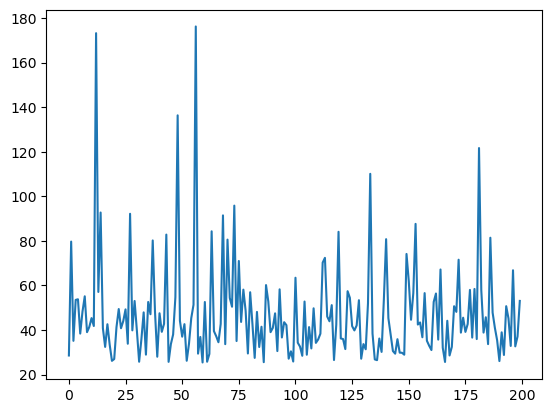

46.97871497569802


In [212]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV

k = 200

data = k_fold_split(data, k)
data_preprocessed = preprocessing(data)
data_preprocessed.drop(['property_id', 'host_id'], axis=1, inplace=True)
data_preprocessed = data_preprocessed.select_dtypes(include=['int64', 'float64'])  # Keep only numerical columns

simple_imputer = SimpleImputer(strategy='mean')
standard_scaler = StandardScaler()

en_model = ElasticNet()
param_grid_en = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                 'l1_ratio': [0.25, 0.5, 0.75],
                 'max_iter': [10000]}

xgb_model = xgb.XGBRegressor()
param_grid_xgb = {'learning_rate': [0.01, 0.1, 0.2],
                  'max_depth': [3, 5, 7],
                  'min_child_weight': [1, 3, 5],
                  'subsample': [0.8, 0.9, 1],
                  'colsample_bytree': [0.8, 0.9, 1],
                  'n_estimators': [100, 500, 1000]}

ridge_model = Ridge()
param_grid_ridge = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                    'max_iter': [10000]}

lasso_model = Lasso()
param_grid_lasso = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                    'max_iter': [10000]}

svr_model = SVR(kernel='poly')
param_grid_svr = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'C': [0.1, 1, 10],
                  'gamma': ['scale', 'auto'],
                  'epsilon': [0.1, 0.2, 0.3]}

lgbm_model = LGBMRegressor()
param_grid_lgbm = {'learning_rate': [0.01, 0.1, 0.2],
                   'max_depth': [3, 5, 7],
                   'num_leaves': [31, 63, 127],
                   'subsample': [0.8, 0.9, 1],
                   'colsample_bytree': [0.8, 0.9, 1],
                   'n_estimators': [100, 500, 1000]}


rmse_list = []

# Loop through folds
for i in range(k):

    # Split data into train and test
    train = data_preprocessed[data_preprocessed['fold'] != i]
    test = data_preprocessed[data_preprocessed['fold'] == i]

    # Remove outliers from training set
    train_temp = simple_imputer.fit_transform(train)
    isolation_forest = IsolationForest(n_estimators=100, contamination='auto')
    isolation_forest.fit(train_temp)
    outliers = isolation_forest.predict(train_temp) == -1
    train = train[~outliers]

    # Split train into X and y
    X_train = train.drop(['target','fold'], axis=1)
    y_train = train['target']

    # Split test into X and y
    X_test = test.drop(['target','fold'], axis=1)
    y_test = test['target']

    # Feature selection variance threshold
    '''
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    X_train = sel.fit_transform(X_train)
    X_test = sel.transform(X_test)
    '''

    # Feature selection recursive feature elimination
    '''
    X_train = simple_imputer.fit_transform(X_train)
    X_test = simple_imputer.transform(X_test)
    rfe = RFE(en_model, n_features_to_select=5)
    rfe.fit(X_train, y_train)
    X_train = rfe.transform(X_train)
    X_test = rfe.transform(X_test)
    '''

    X_train_transformed = standard_scaler.fit_transform(simple_imputer.fit_transform(X_train))
    X_test_transformed = standard_scaler.fit_transform(simple_imputer.transform(X_test))

    # Elastic net
    en_model.fit(X_train_transformed, y_train)
    y_train_en = en_model.predict(X_train_transformed)
    y_pred_en = en_model.predict(X_test_transformed)

    # XGBoost
    xgb_model.fit(X_train_transformed, y_train)
    y_train_xgb = xgb_model.predict(X_train_transformed)
    y_pred_xgb = xgb_model.predict(X_test_transformed)

    # Lasso
    lasso_model.fit(X_train_transformed, y_train)
    y_train_lasso = lasso_model.predict(X_train_transformed)
    y_pred_lasso = lasso_model.predict(X_test_transformed)

    # Ridge
    ridge_model.fit(X_train_transformed, y_train)
    y_train_ridge = ridge_model.predict(X_train_transformed)
    y_pred_ridge = ridge_model.predict(X_test_transformed)

    # SVR
    svr_model.fit(X_train_transformed, y_train)
    y_train_svr = svr_model.predict(X_train_transformed)
    y_pred_svr = svr_model.predict(X_test_transformed)

    # LGBM
    lgbm_model.fit(X_train_transformed, y_train)
    y_train_lgbm = lgbm_model.predict(X_train_transformed)
    y_pred_lgbm = lgbm_model.predict(X_test_transformed)


    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    # Compile the model
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.RMSprop())

    # Set up the initial state
    best_rmse = float('inf')  # Initialize the best RMSE to infinity
    patience = 10  # Set the number of epochs to wait before stopping if no improvement
    no_improvement = 0  # Initialize the counter for the number of epochs with no improvement

    # Train the model
    while no_improvement < patience:
        # Fit the model for one epoch
        model.fit(X_train_transformed, y_train, epochs=1, verbose=0)
        
        # Evaluate the model on the test set
        y_pred_nn = model.predict(X_test_transformed)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
        
        # Check if the RMSE has improved
        if rmse < best_rmse:
            best_rmse = rmse
            no_improvement = 0  # Reset the counter
        else:
            no_improvement += 1
        
        # Print the current RMSE and the best RMSE so far
        print(f'RMSE: {rmse:.4f}, Best RMSE: {best_rmse:.4f}')
        
        # Check if the maximum number of epochs has been reached
        if epochs == 0:
            break
        else:
            epochs -= 1

    y_pred_nn = model.predict(X_test_transformed)

    # Calculate RMSE for each model
    rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
    rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
    rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))

    # Print RMSE for each model
    print(f'Fold {i}: RMSE Elastic net = {rmse_en}')
    print(f'Fold {i}: RMSE XGBoost = {rmse_xgb}')
    print(f'Fold {i}: RMSE Lasso = {rmse_lasso}')
    print(f'Fold {i}: RMSE Ridge = {rmse_ridge}')
    print(f'Fold {i}: RMSE SVR = {rmse_svr}')
    print(f'Fold {i}: RMSE LGBM = {rmse_lgbm}')
    print(f'Fold {i}: RMSE NN = {rmse_nn}')

    '''
    # Save RMSE to a list
    rmse_list.append(rmse_en)
    rmse_list.append(rmse_xgb)
    rmse_list.append(rmse_lasso)
    rmse_list.append(rmse_ridge)
    rmse_list.append(rmse_svr)
    rmse_list.append(rmse_lgbm)
    rmse_list.append(rmse_nn)
    '''
    
    # Stacking
    y_pred = 0.20*y_pred_en + 0.00*y_pred_xgb + 0.20*y_pred_lasso + 0.2*y_pred_ridge + 0.15*y_pred_svr + 0.10*y_pred_lgbm + 0.15*y_pred_nn.flatten()
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)

    print(f'Fold {i}: RMSE stacked = {rmse}')

    '''
    # Save RMSE to a list
    rmse_list.append(rmse)
    '''

# Calculate average RMSE
print(f'Average RMSE = {np.mean(rmse_list)}')

# plot rmse
import matplotlib.pyplot as plt
plt.plot(rmse_list)
plt.show()
print(np.mean(rmse_list))

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
21/21 [==============================] - 0s 1ms/step
RMSE: 46.7878, Best RMSE: 46.7878
21/21 [==============================] - 0s 1ms/step
Fold 0: RMSE Elastic net = 45.39070396220785
Fold 0: RMSE XGBoost = 58.20573266308961
Fold 0: RMSE Lasso = 45.29098773966472
Fold 0: RMSE Ridge = 47.13835720660648
Fold 0: RMSE SVR = 47.18774370545116
Fold 0: RMSE LGBM = 45.402630750900805
Fold 0: RMSE NN = 46.787777536982134
Fold 0: RMSE stacked = 45.13764910868318
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
19/19 [==============================] - 0s 1ms/step
RMSE: 63.5649, Best RMSE: 63.5649
19/19 [==============================] - 0s 1ms/step
Fold 1: RMSE Elastic net = 62.7348863396998
Fold 1: RMSE XGBoost = 68.66949911275674
Fold 1: RMSE Lasso = 62.77526617767802
Fold 1: RMSE Ridge = 63.1068960949

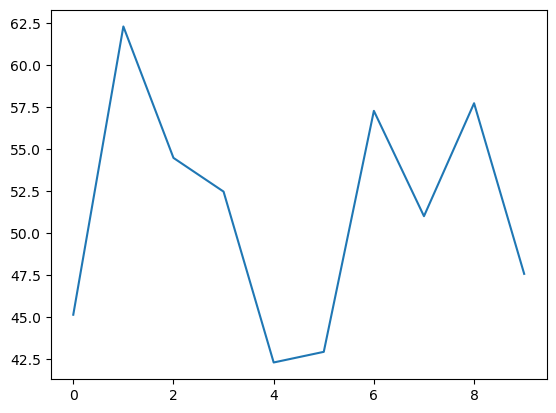

51.31878337465334


In [211]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV

k = 10

data = k_fold_split(data, k)
data_preprocessed = preprocessing(data)
data_preprocessed.drop(['property_id', 'host_id'], axis=1, inplace=True)
data_preprocessed = data_preprocessed.select_dtypes(include=['int64', 'float64'])  # Keep only numerical columns

simple_imputer = SimpleImputer(strategy='mean')
standard_scaler = StandardScaler()

en_model = ElasticNet()
param_grid_en = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                 'l1_ratio': [0.25, 0.5, 0.75],
                 'max_iter': [10000]}

xgb_model = xgb.XGBRegressor()
param_grid_xgb = {'learning_rate': [0.01, 0.1, 0.2],
                  'max_depth': [3, 5, 7],
                  'min_child_weight': [1, 3, 5],
                  'subsample': [0.8, 0.9, 1],
                  'colsample_bytree': [0.8, 0.9, 1],
                  'n_estimators': [100, 500, 1000]}

ridge_model = Ridge()
param_grid_ridge = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                    'max_iter': [10000]}

lasso_model = Lasso()
param_grid_lasso = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                    'max_iter': [10000]}

svr_model = SVR(kernel='poly')
param_grid_svr = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'C': [0.1, 1, 10],
                  'gamma': ['scale', 'auto'],
                  'epsilon': [0.1, 0.2, 0.3]}

lgbm_model = LGBMRegressor()
param_grid_lgbm = {'learning_rate': [0.01],
                   'num_leaves': [10, 20, 30],
                   'max_depth': [3, 5, 7],
                   'min_data_in_leaf': [10, 20, 30]}

lin_model = LinearRegression()

rmse_list = []

# Loop through folds
for i in range(k):

    # Split data into train and test
    train = data_preprocessed[data_preprocessed['fold'] != i]
    test = data_preprocessed[data_preprocessed['fold'] == i]

    # Remove outliers from training set
    train_temp = simple_imputer.fit_transform(train)
    isolation_forest = IsolationForest(n_estimators=100, contamination='auto')
    isolation_forest.fit(train_temp)
    outliers = isolation_forest.predict(train_temp) == -1
    train = train[~outliers]

    # Split train into X and y
    X_train = train.drop(['target','fold'], axis=1)
    y_train = train['target']

    # Split test into X and y
    X_test = test.drop(['target','fold'], axis=1)
    y_test = test['target']

    # Feature selection variance threshold
    '''
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    X_train = sel.fit_transform(X_train)
    X_test = sel.transform(X_test)
    '''

    # Feature selection recursive feature elimination
    '''
    X_train = simple_imputer.fit_transform(X_train)
    X_test = simple_imputer.transform(X_test)
    rfe = RFE(en_model, n_features_to_select=5)
    rfe.fit(X_train, y_train)
    X_train = rfe.transform(X_train)
    X_test = rfe.transform(X_test)
    '''

    X_train_transformed = standard_scaler.fit_transform(simple_imputer.fit_transform(X_train))
    X_test_transformed = standard_scaler.fit_transform(simple_imputer.transform(X_test))

    # Elastic net
    en_model.fit(X_train_transformed, y_train)
    y_train_en = en_model.predict(X_train_transformed)
    y_pred_en = en_model.predict(X_test_transformed)

    # XGBoost
    xgb_model.fit(X_train_transformed, y_train)
    y_train_xgb = xgb_model.predict(X_train_transformed)
    y_pred_xgb = xgb_model.predict(X_test_transformed)

    # Lasso
    lasso_model.fit(X_train_transformed, y_train)
    y_train_lasso = lasso_model.predict(X_train_transformed)
    y_pred_lasso = lasso_model.predict(X_test_transformed)

    # Ridge
    ridge_model.fit(X_train_transformed, y_train)
    y_train_ridge = ridge_model.predict(X_train_transformed)
    y_pred_ridge = ridge_model.predict(X_test_transformed)

    # SVR
    svr_model.fit(X_train_transformed, y_train)
    y_train_svr = svr_model.predict(X_train_transformed)
    y_pred_svr = svr_model.predict(X_test_transformed)

    # LGBM
    grid_search_lgbm = GridSearchCV(lgbm_model, param_grid=param_grid_lgbm, cv=5, n_jobs=-1)
    grid_search_lgbm.fit(X_train_transformed, y_train)
    y_train_lgbm = grid_search_lgbm.predict(X_train_transformed)
    y_pred_lgbm = grid_search_lgbm.predict(X_test_transformed)


    # Neural network
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=[X_train.shape[1]]),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    # Compile the model
    nn_model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.RMSprop())
    # Set up the initial state
    best_rmse = float('inf')  # Initialize the best RMSE to infinity
    patience = 10  # Set the number of epochs to wait before stopping if no improvement
    no_improvement = 0  # Initialize the counter for the number of epochs with no improvement
    # Train the model
    while no_improvement < patience:
        # Fit the model for one epoch
        nn_model.fit(X_train_transformed, y_train, epochs=1, verbose=0)
        
        # Evaluate the model on the test set
        y_pred_nn = nn_model.predict(X_test_transformed)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
        
        # Check if the RMSE has improved
        if rmse < best_rmse:
            best_rmse = rmse
            no_improvement = 0  # Reset the counter
        else:
            no_improvement += 1
        
        # Print the current RMSE and the best RMSE so far
        print(f'RMSE: {rmse:.4f}, Best RMSE: {best_rmse:.4f}')
        
        # Check if the maximum number of epochs has been reached
        if epochs == 0:
            break
        else:
            epochs -= 1
    y_train_nn = nn_model.predict(X_train_transformed)
    y_pred_nn = nn_model.predict(X_test_transformed)

    # Calculate RMSE for each model
    rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
    rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
    rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
    rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))

    # Print RMSE for each model
    print(f'Fold {i}: RMSE Elastic net = {rmse_en}')
    print(f'Fold {i}: RMSE XGBoost = {rmse_xgb}')
    print(f'Fold {i}: RMSE Lasso = {rmse_lasso}')
    print(f'Fold {i}: RMSE Ridge = {rmse_ridge}')
    print(f'Fold {i}: RMSE SVR = {rmse_svr}')
    print(f'Fold {i}: RMSE LGBM = {rmse_lgbm}')
    print(f'Fold {i}: RMSE NN = {rmse_nn}')
    
    # Stacking
    X_train_stack = np.column_stack((y_train_en, y_train_xgb, y_train_lasso, y_train_ridge, y_train_svr, y_train_lgbm, y_train_nn.flatten()))
    X_test_stack = np.column_stack((y_pred_en, y_pred_xgb, y_pred_lasso, y_pred_ridge, y_pred_svr, y_pred_lgbm, y_pred_nn.flatten()))
    lin_model.fit(X_train_stack, y_train)
    y_pred = lin_model.predict(X_test_stack)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_list.append(rmse)


    print(f'Fold {i}: RMSE stacked = {rmse}')

    '''
    # Save RMSE to a list
    rmse_list.append(rmse)
    '''

# Calculate average RMSE
print(f'Average RMSE = {np.mean(rmse_list)}')

# plot rmse
import matplotlib.pyplot as plt
plt.plot(rmse_list)
plt.show()
print(np.mean(rmse_list))

In [202]:
param_grid_lgbm = {'learning_rate': [0.01],
                   'num_leaves': [10, 20, 30],
                   'max_depth': [3, 5, 7],
                   'min_data_in_leaf': [10, 20, 30]}

grid_search_lgbm = GridSearchCV(lgbm_model, param_grid=param_grid_lgbm, cv=5, n_jobs=-1, verbose=1)
grid_search_lgbm.fit(X_train_transformed, y_train)
y_pred_lgbm = grid_search_lgbm.predict(X_test_transformed)

# print rmse
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
print(rmse)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
56.30678868205078


In [227]:
# count  sum of unique values in data host_id
data['host_id'].value_counts().shape

(4919,)

Fold 0: RMSE Elastic net = 44.04684227994347
Fold 1: RMSE Elastic net = 53.235467762152076
Fold 2: RMSE Elastic net = 55.66694067653358
Fold 3: RMSE Elastic net = 45.7524267082025
Fold 4: RMSE Elastic net = 42.43099293061429
Fold 5: RMSE Elastic net = 62.25090231238484
Fold 6: RMSE Elastic net = 60.254586116642386
Fold 7: RMSE Elastic net = 51.13883124342531
Fold 8: RMSE Elastic net = 47.24546561266554
Fold 9: RMSE Elastic net = 53.84748467891066
Average RMSE = 51.58699403214747


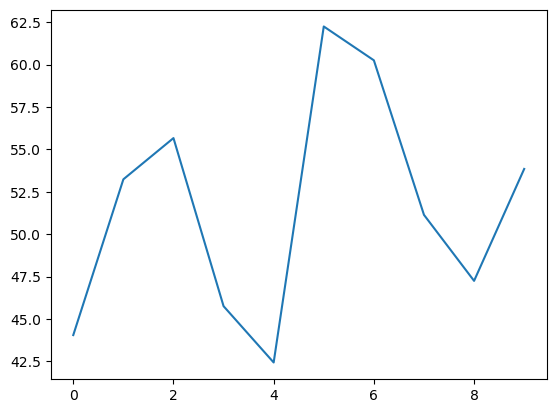

51.58699403214747


In [264]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import GridSearchCV

k = 10

data = k_fold_split(data, k)
data_preprocessed = preprocessing(data)
data_preprocessed.drop(['property_id', 'host_id'], axis=1, inplace=True)
data_preprocessed = data_preprocessed.select_dtypes(include=['int64', 'float64'])  # Keep only numerical columns

simple_imputer = SimpleImputer(strategy='mean')
standard_scaler = StandardScaler()

en_model = ElasticNet(
    alpha=10,
    l1_ratio=0.5
)
param_grid_en = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                 'l1_ratio': [0.4, 0.6, 0.8],
                 'max_iter': [10000],
                 'warm_start': [True]}

rmse_list = []

# Loop through folds
for i in range(k):

    # Split data into train and test
    train = data_preprocessed[data_preprocessed['fold'] != i]
    test = data_preprocessed[data_preprocessed['fold'] == i]

    # Remove outliers from training set
    train_temp = simple_imputer.fit_transform(train)
    isolation_forest = IsolationForest(n_estimators=100, contamination='auto')
    isolation_forest.fit(train_temp)
    outliers = isolation_forest.predict(train_temp) == -1
    train = train[~outliers]
    

    # Split train into X and y
    X_train = train.drop(['target','fold'], axis=1)
    y_train = train['target']

    # Split test into X and y
    X_test = test.drop(['target','fold'], axis=1)
    y_test = test['target']

    # Feature selection variance threshold
    '''
    sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    X_train = sel.fit_transform(X_train)
    X_test = sel.transform(X_test)
    '''

    # Feature selection recursive feature elimination
    '''
    X_train = simple_imputer.fit_transform(X_train)
    X_test = simple_imputer.transform(X_test)
    rfe = RFE(en_model, n_features_to_select=5)
    rfe.fit(X_train, y_train)
    X_train = rfe.transform(X_train)
    X_test = rfe.transform(X_test)
    '''

    X_train_transformed = standard_scaler.fit_transform(simple_imputer.fit_transform(X_train))
    X_test_transformed = standard_scaler.fit_transform(simple_imputer.transform(X_test))

    '''
    # Elastic net
    grid_search_en = GridSearchCV(en_model, param_grid=param_grid_en, cv=5, n_jobs=-1, verbose=4)
    grid_search_en.fit(X_train_transformed, y_train)
    y_pred_en = grid_search_lgbm.predict(X_test_transformed)
    '''

    # Elastic net
    en_model.fit(X_train_transformed, y_train)
    y_train_en = en_model.predict(X_train_transformed)
    y_pred_en = en_model.predict(X_test_transformed)

    # Calculate RMSE for each model
    rmse_en = np.sqrt(mean_squared_error(y_test, y_pred_en))

    # Print RMSE for each model
    print(f'Fold {i}: RMSE Elastic net = {rmse_en}')
    rmse_list.append(rmse_en)

# Calculate average RMSE
print(f'Average RMSE = {np.mean(rmse_list)}')

# plot rmse
import matplotlib.pyplot as plt
plt.plot(rmse_list)
plt.show()
print(np.mean(rmse_list))

In [265]:
print(y_pred_en)

[67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419 67.86986419
 67.86986419 67.86986419 67.86986419 67.86986419 67

In [220]:
# get en_model params
print(en_model.get_params())

{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


In [267]:
data_train = pd.read_csv('../assignment-1/data/train.csv')
data_test = pd.read_csv('../assignment-1/data/test.csv')

In [268]:
data_preprocessed_train = preprocessing(data_train)
data_preprocessed_test = preprocessing(data_test)

data_preprocessed_train.drop(['property_id', 'host_id'], axis=1, inplace=True)
data_preprocessed_test.drop(['property_id', 'host_id'], axis=1, inplace=True)

data_preprocessed_train = data_preprocessed_train.select_dtypes(include=['int64', 'float64'])  # Keep only numerical columns
data_preprocessed_test = data_preprocessed_test.select_dtypes(include=['int64', 'float64'])  # Keep only numerical columns
data_preprocessed_test.drop(['property_zipcode'], axis=1, inplace=True)  # in test set, property_zipcode is float (not in train set)

simple_imputer = SimpleImputer(strategy='mean')
standard_scaler = StandardScaler()

en_model = ElasticNet(
    alpha=10,
    l1_ratio=0.5
)


# Split data into train and test
train = data_preprocessed_train
test = data_preprocessed_test


# Remove outliers from training set
train_temp = simple_imputer.fit_transform(train)
isolation_forest = IsolationForest(n_estimators=100, contamination='auto')
isolation_forest.fit(train_temp)
outliers = isolation_forest.predict(train_temp) == -1
train = train[~outliers]


# Split train into X and y
X_train = train.drop(['target'], axis=1)
y_train = train['target']

# Split test into X and y
X_test = test

X_train_transformed = standard_scaler.fit_transform(simple_imputer.fit_transform(X_train))
X_test_transformed = standard_scaler.fit_transform(simple_imputer.transform(X_test))


# Elastic net
en_model.fit(X_train_transformed, y_train)
y_pred_en = en_model.predict(X_test_transformed)



In [318]:
data = pd.read_csv('../assignment-1/data/train.csv')
data_test = pd.read_csv('../assignment-1/data/test.csv')
y_pred_en = np.mean(data.target)

In [319]:
# combine property_id as ID and y_pred_en as PRED in a dataframe
df = pd.DataFrame({'ID': data_test.property_id, 'PRED': y_pred_en})

In [320]:
df

,ID,PRED
0,6501,67.899923
1,6502,67.899923
2,6503,67.899923
3,6504,67.899923
4,6505,67.899923
...,...,...
914,7415,67.899923
915,7416,67.899923
916,7417,67.899923
917,7418,67.899923


In [321]:
# save as csv
df.to_csv('submission.csv', index=False)

C:\Users\herre\AppData\Local\Temp\ipykernel_10272\3694252203.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


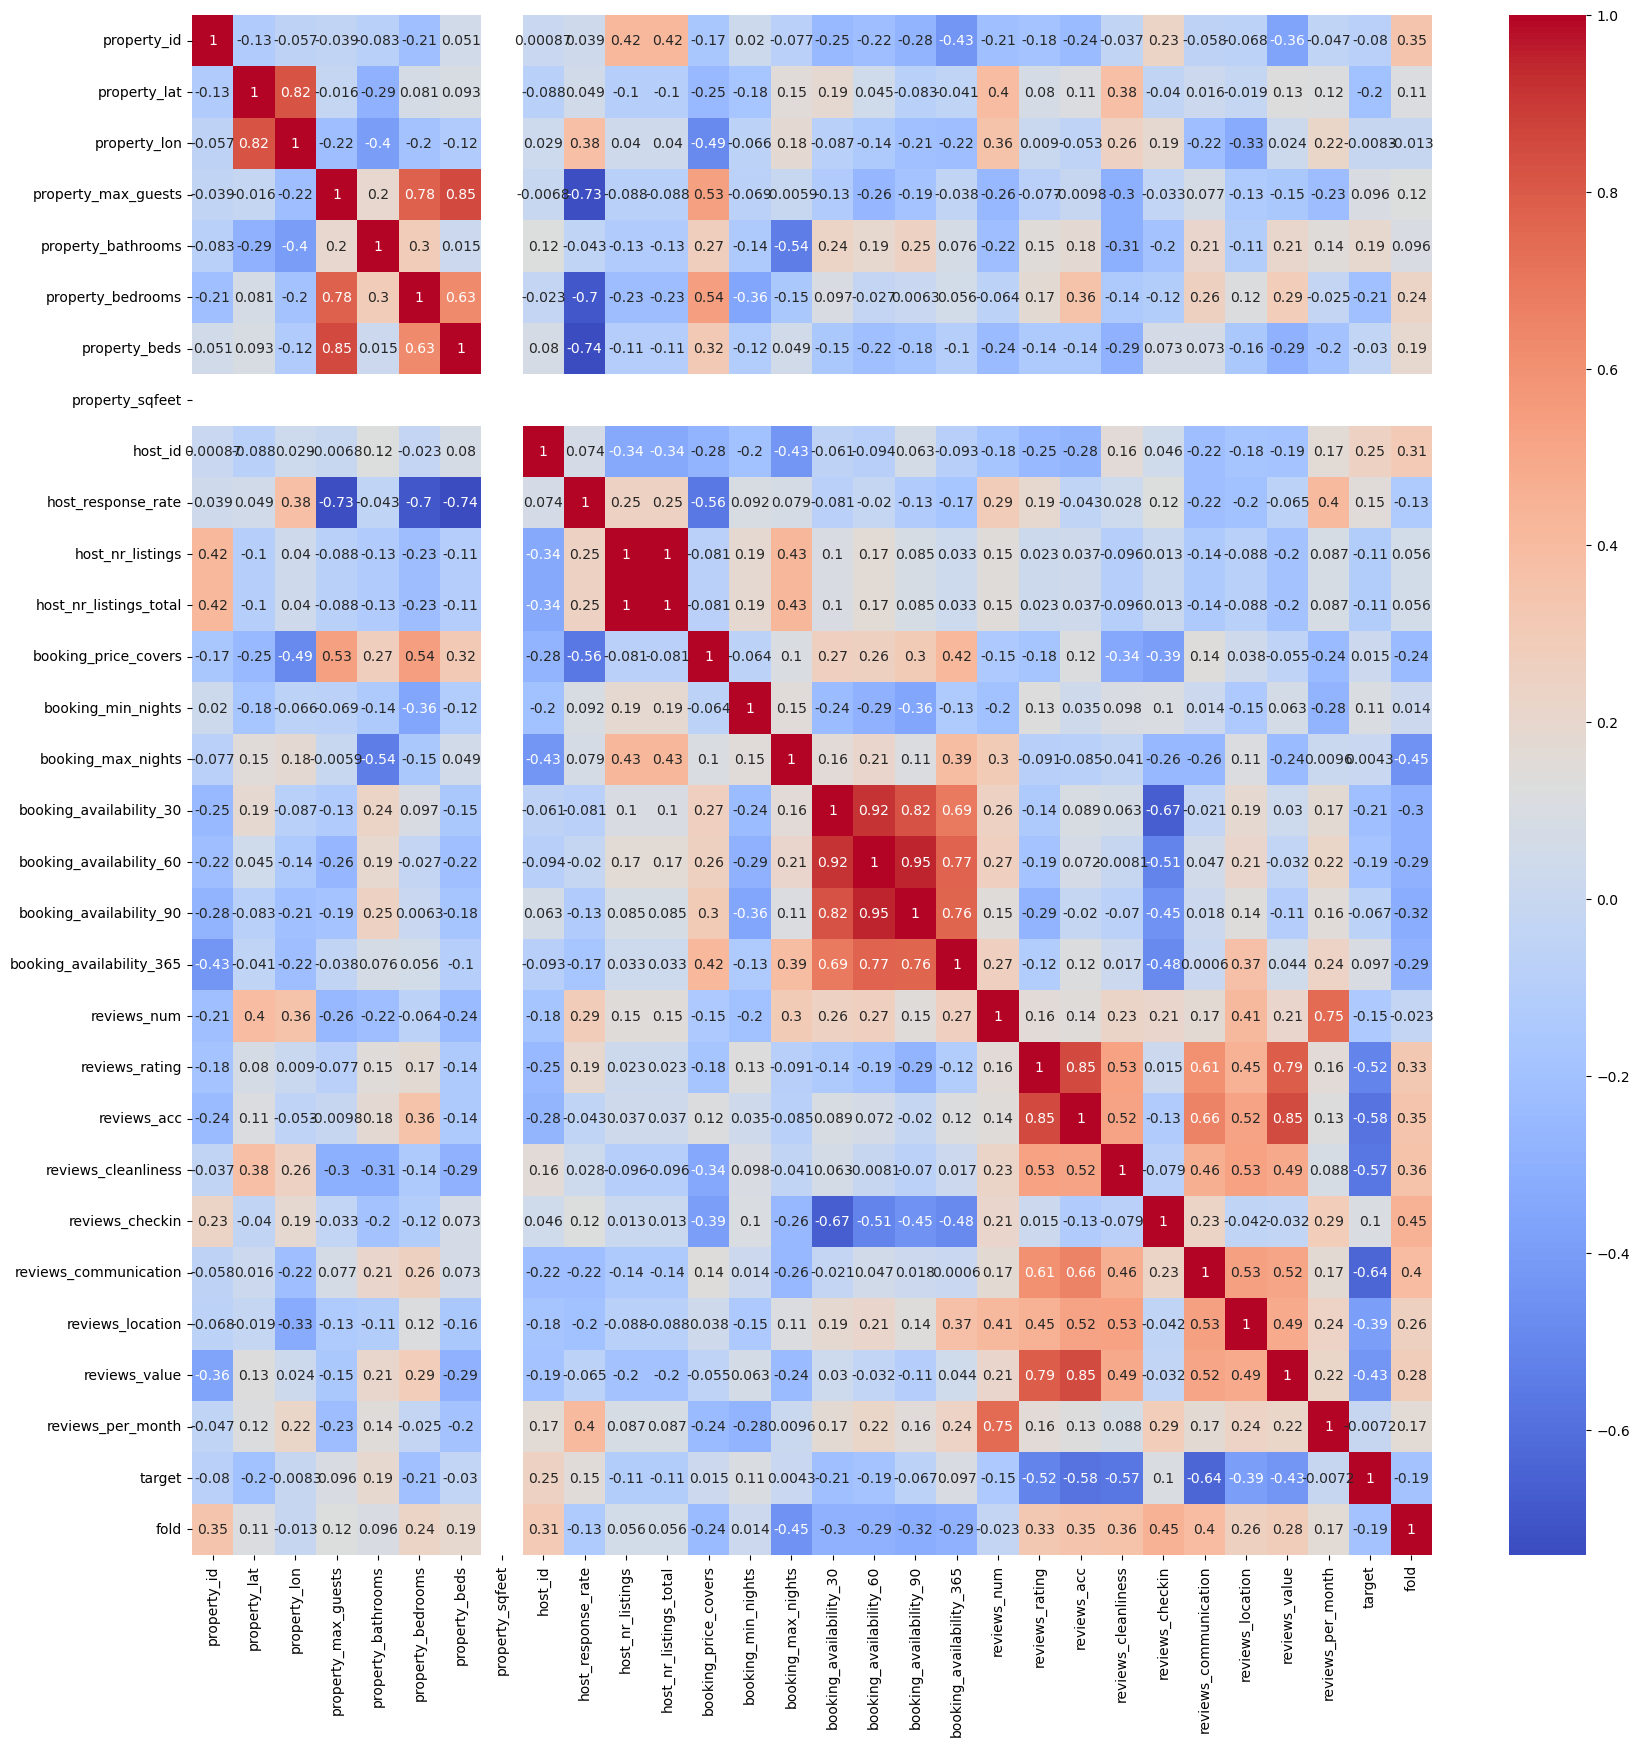

In [276]:
# create correlation matrix for numerical features
corr_matrix = data.corr()

# plot correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


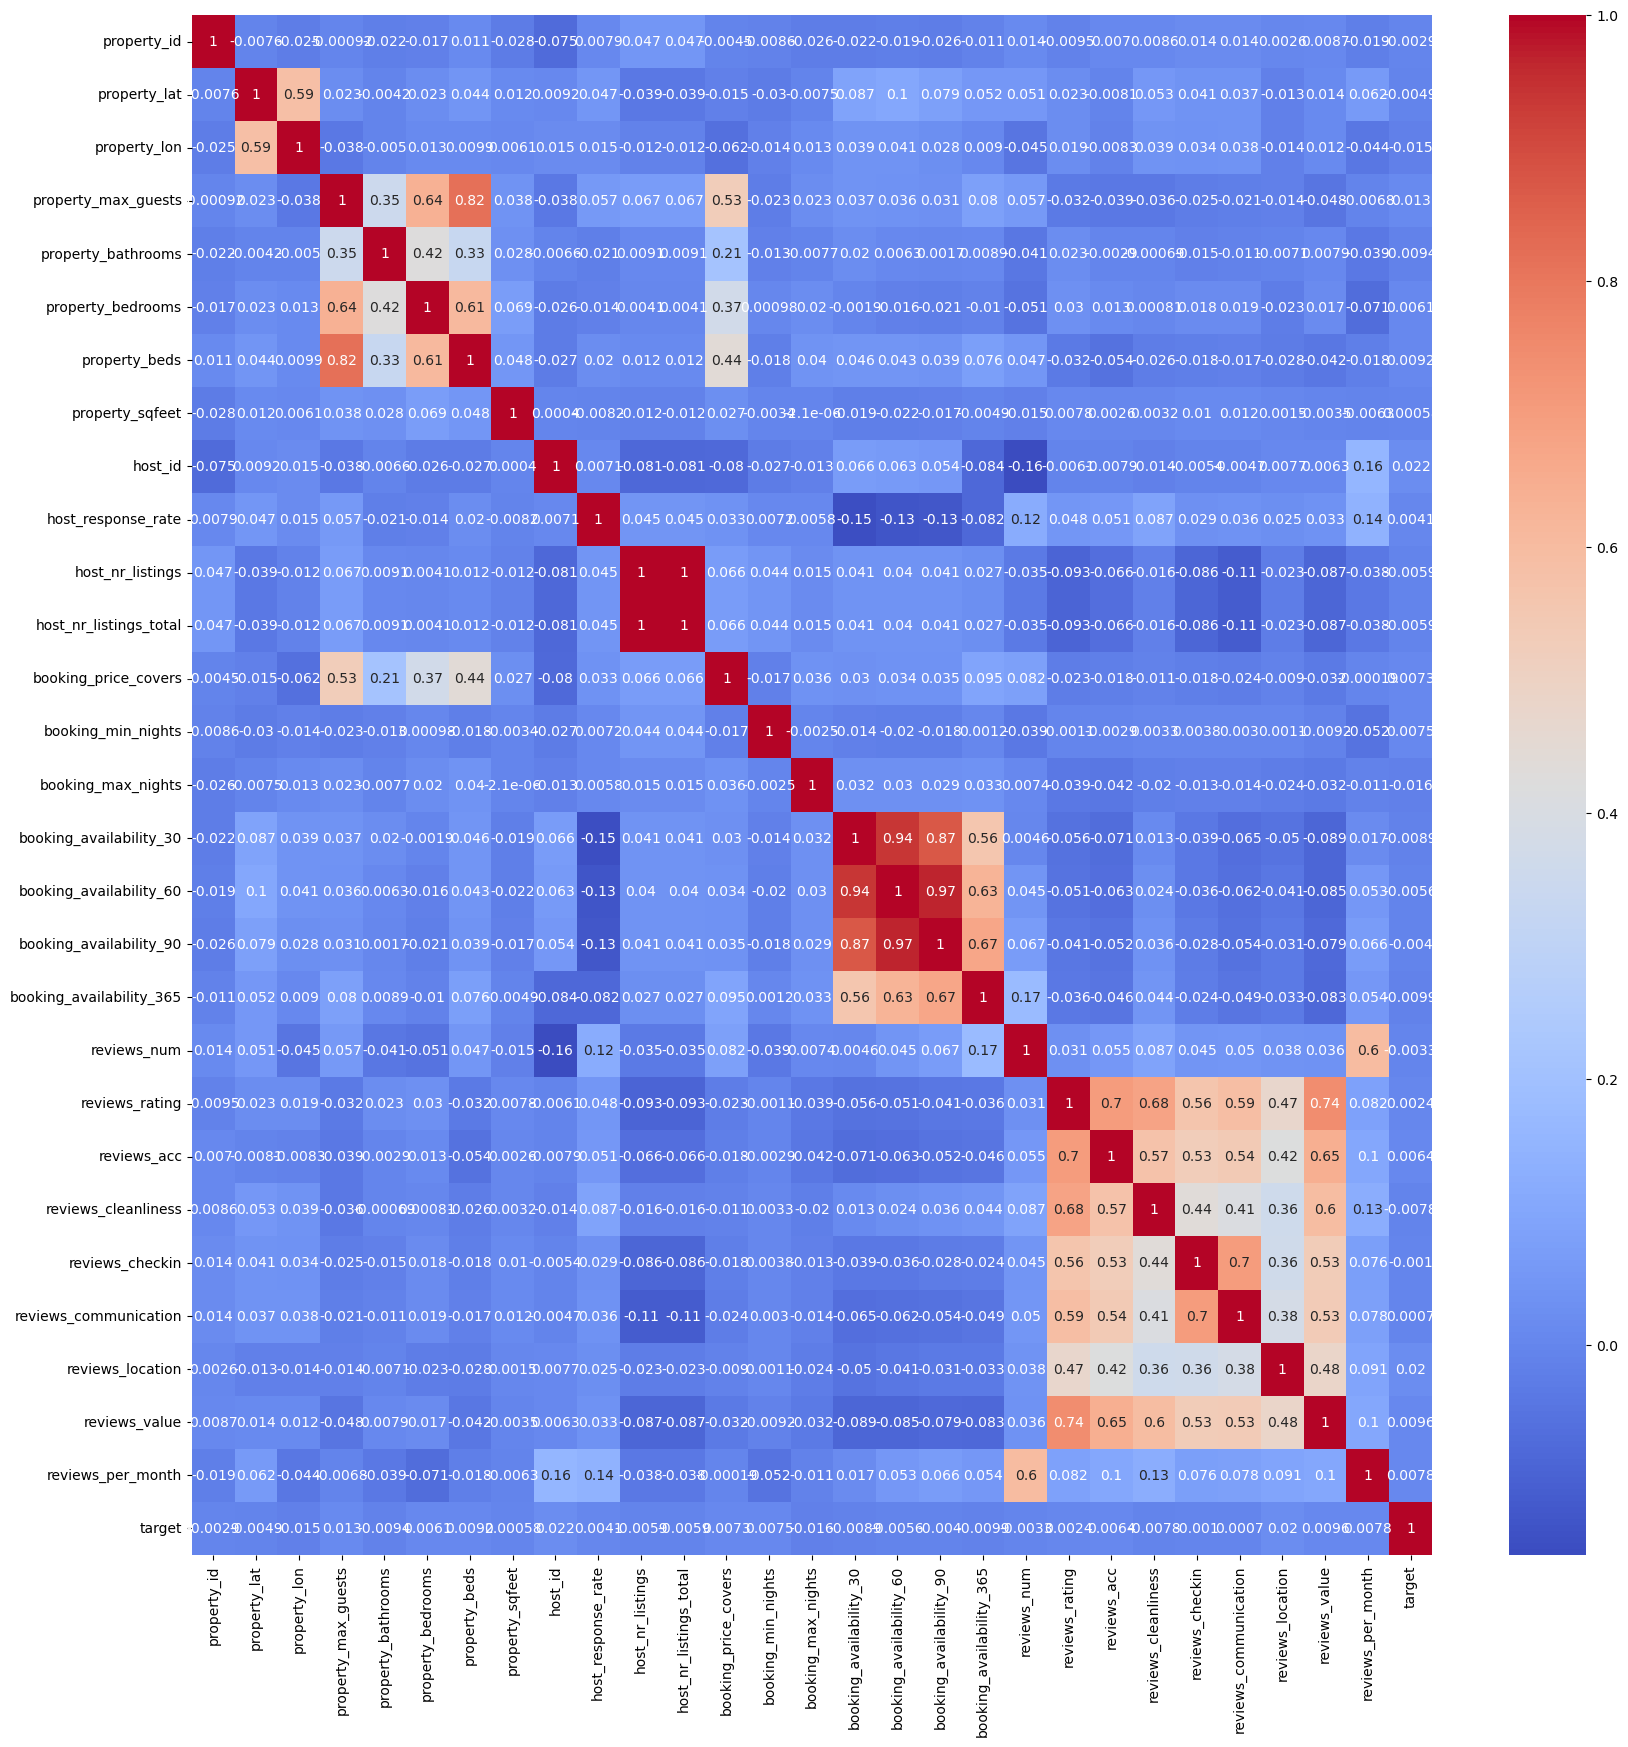

In [296]:
df = pd.read_csv('../assignment-1/data/train.csv')

# Select only numerical columns
num_cols = df.select_dtypes(include=np.number).columns

# Mean impute missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Define the constant
property_max_guests = df["booking_price_covers"].values[0]

# Multiply the columns by the constant
df_multiplied = df[num_cols].mul(property_max_guests)

# Calculate the correlation matrix
corr_matrix = df_multiplied.corr()

# plot correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [312]:
# select target
y = df['target']

# select property_beds
b = df['property_bathrooms']

corr = []
# loop through length of y
for i in range(len(y)):
    
    # compute correlation between y and b
    corr.append(np.corrcoef(y, b)[0, 1])

    # shift b array
    b = np.roll(b, 1)



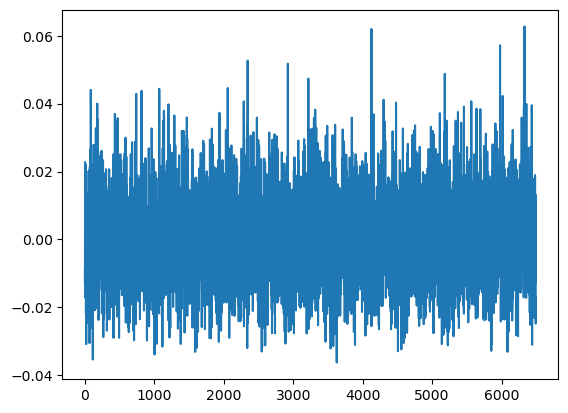

In [313]:
# plot correlation
import matplotlib.pyplot as plt
plt.plot(corr)
plt.show()
